In [1]:
# importing necessary libraries
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from google.colab import drive
import cv2
import numpy as np
import os
import xml.etree.cElementTree as ET
from google.colab.patches import cv2_imshow
# setting the seed
SEED = 42
np.random.seed(SEED)

In [2]:
# mounting derive
drive.mount('/content/gdrive', force_remount=True)
!unzip /content/gdrive/MyDrive/challenge1.zip > /dev/null
!unzip /content/gdrive/MyDrive/yolov7.zip > /dev/null

Mounted at /content/gdrive


In [ ]:
# result visiualization function using tensorboard
def monitor_tensorboard():
    %load_ext tensorboard
    %tensorboard --logdir runs/train

In [ ]:
#cloning yolov7
!# Download YOLOv7 code
!git clone https://github.com/WongKinYiu/yolov7
%cd yolov7
!ls

import torch
import os
from IPython.display import Image, clear_output  # to display images

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Cloning into 'yolov7'...
remote: Enumerating objects: 1127, done.
remote: Total 1127 (delta 0), reused 0 (delta 0), pack-reused 1127
Receiving objects: 100% (1127/1127), 69.93 MiB | 28.52 MiB/s, done.
Resolving deltas: 100% (522/522), done.
/content/yolov7
cfg	detect.py  hubconf.py  models	  requirements.txt  tools	  utils
data	export.py  inference   paper	  scripts	    train_aux.py
deploy	figure	   LICENSE.md  README.md  test.py	    train.py
Setup complete. Using torch 1.13.1+cu116 (Tesla T4)


In [ ]:
!git clone https://github.com/Payamsed/yolov7-custom-object-detection-tracking.git

Cloning into 'yolov7-custom-object-detection-tracking'...
remote: Enumerating objects: 26, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 26 (delta 4), reused 20 (delta 4), pack-reused 5
Unpacking objects: 100% (26/26), 77.89 MiB | 10.12 MiB/s, done.


In [3]:
# check the requirements are satisfied
!pip install -r /content/yolov7/requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 KB 11.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 78.1 MB/s eta 0:00:00
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110474 sha256=f0372a358765547762f08cb349416a8a726409c423efa33c1e954c0e91ac3269
  Stored in directory: /root/.cache/pip/wheels/fe/f6/cb/40331472edf4fd399b8cad02973c6acbdf26898342928327fe
Successfully built filterpy


In [ ]:
def extract_images_from_video(video_path, annotations_path, target_size, frame_rate, save_directory):
    if not os.path.exists(save_directory):
        os.makedirs(save_directory)
    vid = cv2.VideoCapture(video_path)
    with open(annotations_path, 'r') as f:
        annotations = json.load(f)
    index = 0
    c = 0
    while True:
        ret, frame = vid.read()
        if not ret:
            break
        if index % frame_rate == 0:
            class_count = 0
            for annotation in annotations['annotations']:
                if annotation['image_id'] == index:
                    class_count += 1
            if class_count >= 2:
                name = os.path.join(save_directory, str(index) + '.jpg')
                cv2.imwrite(name, cv2.resize(frame, target_size))
                c += 1
        index += 1
    vid.release()
    print(f"{c} images extracted and saved at {save_directory}")

extract_images_from_video(
    '/content/challenge/images/train/train.mp4',
    '/content/challenge/annotations/instances_train.json',
    (640, 640),
    18,
    '/content/dataset_t/images/train'
)

extract_images_from_video(
    '/content/challenge/images/val/val.mp4',
    '/content/challenge/annotations/instances_val.json',
    (640, 640),
    18,
    '/content/dataset_t/images/val'
)




332 images extracted and saved at /content/dataset_t/images/train
77 images extracted and saved at /content/dataset_t/images/val


In [ ]:
# annotation extraction
import json
import os

os.makedirs('/content/dataset_t/labels')
os.makedirs('/content/dataset_t/labels/train')
os.makedirs('/content/dataset_t/labels/val')
os.makedirs('/content/dataset_t/labels/test')
# function convert coco format to yolo
import json

def coco_to_yolo(coco_json_file, yolo_txt_folder):
    with open(coco_json_file) as json_file:
        coco = json.load(json_file)

    class_mapping = {category['id']: i for i, category in enumerate(coco['categories'])}
    
    for image in coco['images']:
        image_id = image['id']
        image_file = image['file_name']
        image_width = image['width']
        image_height = image['height']
        
        yolo_txt_file = f'{yolo_txt_folder}/{image_id}.txt'
        with open(yolo_txt_file, 'w') as f:
            for annotation in coco['annotations']:
                if annotation['image_id'] == image_id:
                    xmin, ymin, width, height = annotation['bbox']
                    x_center = (xmin + width / 2) / image_width
                    y_center = (ymin + (height +30)/ 2) / image_height
                    width /= image_width
                    height /= image_height
                    
                    class_id = class_mapping[annotation['category_id']]
                    
                    f.write(f'{class_id} {x_center} {y_center} {width} {height}\n')

if __name__ == '__main__':
    # Converting the COCO annotations for the train set
    coco_to_yolo('/content/challenge/annotations/instances_train.json', '/content/dataset_t/labels/train')

    # Converting the COCO annotations for the validation set
    coco_to_yolo('/content/challenge/annotations/instances_val.json', '/content/dataset_t/labels/val')

    # Converting the COCO annotations for the test set
    coco_to_yolo('/content/challenge/annotations/instances_test.json', '/content/dataset_t/labels/test')


In [ ]:
!rm -rf /content/dataset_t

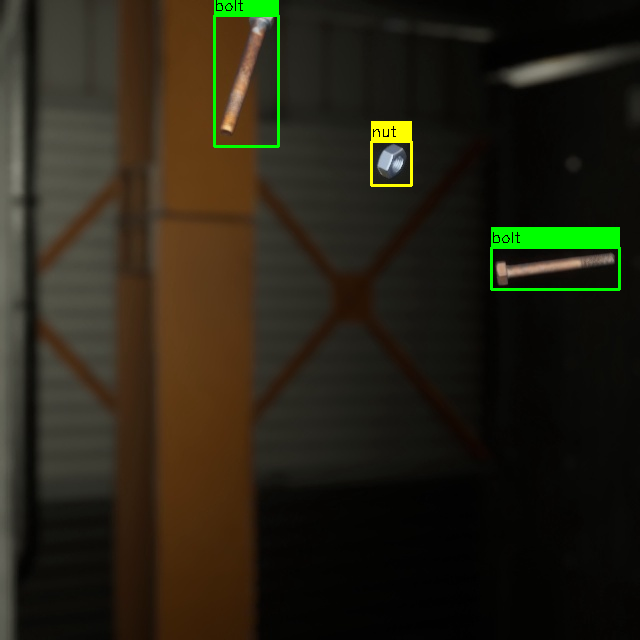

In [ ]:
import cv2

image_path = '/content/dataset_t/images/train/1170.jpg'

image = cv2.imread(image_path)
class_list = ['bolt', 'nut']
colors = [(0, 255, 0), (0, 255, 255)]

height, width, _ = image.shape

with open('/content/dataset_t/labels/train/1170.txt', "r") as file1:
    for line in file1.readlines():
        split = line.split(" ")

        # getting the class id
        class_id = int(split[0])
        color = colors[class_id]
        clazz = class_list[class_id]

        # getting the xywh bounding box coordinates
        x_center, y_center, w, h = float(split[1]), float(split[2]), float(split[3]), float(split[4])

        # re-scaling xywh to the image size
        x_min = int((x_center - w/2) * width)
        y_min = int((y_center - h/2) * height)
        x_max = int((x_center + w/2) * width)
        y_max = int((y_center + h/2) * height)
        box = (x_min, y_min, x_max - x_min, y_max - y_min)

        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), color, 2)
        cv2.rectangle(image, (x_min, y_min - 20), (x_min + x_max - x_min, y_min), color, -1)
        cv2.putText(image, clazz, (x_min, y_min - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0))

cv2_imshow(image)
cv2.waitKey()
cv2.destroyAllWindows()


In [ ]:
# making ymal file for setting directories of val and train for training the model on yolov7
f = open("/content/yolov7/data/Dataset_4.yaml", "a")

f.write("train: ../dataset_t/images/train\n")
f.write("val: ../dataset_t/images/val\n")
f.write("nc: 2 \n")
f.write("names: ['bolt', 'nut']\n")
f.close()

In [46]:
!python train.py --workers 8 --device 0 --batch-size 20 --epochs 80 --data /content/yolov7/data/Dataset_4.yaml --img 640 640 --cfg /content/yolov7/cfg/training/yolov7.yaml --weights yolov7.pt --name yolov7_7 --hyp /content/yolov7/data/hyp.scratch.custom.yaml 

python3: can't open file 'train.py': [Errno 2] No such file or directory


In [ ]:
monitor_tensorboard()

In [47]:
!python /content/yolov7/detect_or_track.py --weights /content/yolov7/best.pt --conf 0.2 --img-size 640 --source /content/challenge/images/test/test.mp4 --track --show-fps

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.2, device='', exist_ok=False, img_size=640, iou_thres=0.45, name='exp', no_trace=False, nobbox=False, nolabel=False, nosave=False, project='runs/detect', save_conf=False, save_txt=False, seed=1, show_fps=True, show_track=False, source='/content/challenge/images/test/test.mp4', thickness=2, track=True, unique_track_color=False, update=False, view_img=False, weights=['/content/yolov7/best.pt'])
YOLOR 🚀 2023-1-1 torch 1.13.1+cu116 CUDA:0 (NVIDIA A100-SXM4-40GB, 40536.125MB)

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse
/usr/local/lib/python3.8/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Model Summary: 314 layers, 3648

In [ ]:
# second method 

# import cv2
# import json
# import subprocess


# os.makedirs('/content/test_f')
# # Load the annotations data from the JSON file
# with open('/content/challenge/annotations/instances_test.json') as f:
#     annotations = json.load(f)

# # Create a dictionary to store the mapping from image_id to track_id
# image_id_to_track_id = {ann['image_id']: ann['track_id'] for ann in annotations["annotations"]}

# # Open the test video
# video = cv2.VideoCapture('/content/challenge/images/test/test.mp4')

# # Get the total number of frames in the video
# total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

# # Loop through all the frames in the video
# for frame_index in range(total_frames):
#     # Read the current frame from the video
#     ret, frame = video.read()
    
#     # Check if the frame was successfully read
#     if not ret:
#         break
        
#     # Get the image_id for the current frame
#     image_id = frame_index + 1
#     if image_id in image_id_to_track_id:
    
#     # Get the track_id for the current frame using the image_id_to_track_id dictionary
#       track_id = image_id_to_track_id[image_id]
    
#       frame_filename = '/content/test_f/frame_{}.jpg'.format(frame_index)
#       cv2.imwrite(frame_filename, frame)
#       subprocess.run(["python", "detect.py", "--weights", "/content/yolov7/runs/train/yolov7_7/weights/best.pt", "--conf", "0.5", "--img-size", "640", "--source", frame_filename], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
#       print(track_id)
#     # Do something with the current frame and the corresponding track_id, such as saving the frame to disk or processing it further
#     # ...

# # Release the video capture
# video.release()
